In [1]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings
import glob
import random
import pickle
import dev_wtp_io_utils
import gc #garbage collection
from nilearn import plotting


KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_rows', 99)

### Load brain data

In [ ]:
test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

In [ ]:
with open('../data/Brain_Data_2sns_60subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)
    
dev_wtp_io_utils.check_BD_against_test_train_set(Brain_Data_allsubs,test_train_set)

In [6]:
with open('../data/Brain_Data_2sns_60subs_grouped.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs_grouped = pickle.load(pkl_file)
    
dev_wtp_io_utils.check_BD_against_test_train_set(Brain_Data_allsubs_grouped,test_train_set)

checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


### Preprocess

In [7]:
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()
print(Brain_Data_allsubs.Y.value_counts())
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
print(Brain_Data_allsubs.Y.value_counts())
print(Brain_Data_allsubs.Y.isnull().value_counts())
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
False    3690
True      150
Name: response, dtype: int64
3690
3840


In [13]:
print(Brain_Data_allsubs_grouped.Y.value_counts())
print(Brain_Data_allsubs_grouped.Y.isnull().value_counts())

6.0    236
7.0    235
5.0    227
8.0    202
Name: response, dtype: int64
False    900
Name: response, dtype: int64


In [8]:
#all_subs_nn_nifti = Brain_Data_allsubs_nn.to_nifti()
#all_subs_nn_nifti_Y = Brain_Data_allsubs_nn.Y
#all_subs_nn_nifti_groups = Brain_Data_allsubs_nn.X.subject
#all_subs_nn_nifti_groups

In [9]:
Brain_Data_allsubs_grouped.Y = Brain_Data_allsubs_grouped.X.response.copy()
print(Brain_Data_allsubs_grouped.Y.value_counts())


6.0    236
7.0    235
5.0    227
8.0    202
Name: response, dtype: int64


In [10]:
#all_subs_grouped_nifti = Brain_Data_allsubs_grouped.to_nifti()
#all_subs_grouped_nifti_Y = Brain_Data_allsubs_grouped.Y
#all_subs_grouped_nifti_groups = Brain_Data_allsubs_grouped.X.subject
#all_subs_grouped_nifti_groups

### Predict

Regressing in nilearn:
 - https://nilearn.github.io/decoding/estimator_choice.html
 - http://www.ncbi.nlm.nih.gov/pubmed/20691790







OK, so that's how you do it. It's pretty straightforward.

So...we won't look at nested cross-validation juuust yet, because the next step is to work out how to train on one set and predict on another. that will definitely require a custom pipeline. Let's get started...

In [19]:
from sklearn.model_selection import KFold,GroupKFold
#def cv_train_test_different_sets(averaged_X,averaged_Y, averaged_groups, individual_X,individual_groups, Y, cv,group_list)
"""
averaged_X: values grouped
averaged_groups: group allocations for the averaged dataset
individual_X: values grouped into averages for testing
cv: a Grouped cross-validator
group_list: name of the groups
"""
averaged_yX = Brain_Data_allsubs_grouped
#averaged_y = all_subs_grouped_nifti_Y
averaged_groups = Brain_Data_allsubs_grouped.X.subject
individual_yX = Brain_Data_allsubs_nn
#individual_y = all_subs_nn_nifti_Y
individual_groups = Brain_Data_allsubs_nn.X.subject
cv=KFold(n_splits=5)

#what we're really doing here is splitting on subjects, so let's make that explicit
#make sure the two groups are equal
assert(set(averaged_groups)==set(individual_groups))

groups_array = np.array(list(set(averaged_groups)))


In [21]:
train_yX = averaged_yX[train_selector]

In [24]:
averaged_yX.shape()

(900, 238955)

In [23]:
train_yX.shape()

(725, 238955)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08439e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.25166e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.33617e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.30641e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.01
overall CV Correlation: 0.53


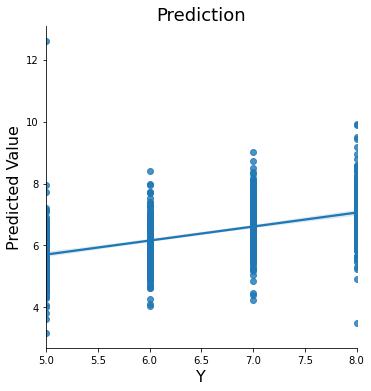

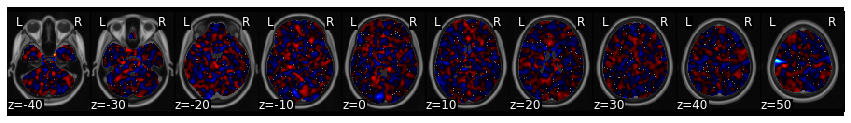

In [27]:
prediction_across_subjects = averaged_yX.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_grouped.X.subject})

hmmmm. Appears there's no way in nltools to train a model on one dataset and then predict it on another?

In [20]:
#the CV that the inner Regressor uses
#cv_inner = GroupKFold(3)

#we actually use KFold on the group names themselves, then filter across that
#that's equivalent to doing a GroupedKFold on the data.
test_scores = []
for train_i,test_i in cv.split(groups_array):
    train_group_items, test_group_items = groups_array[train_i], groups_array[test_i]
    print('In order to test on a training group of ' +
          str(len(train_group_items)) + ' items, holding out the following subjects:' +
          str(test_group_items))
    
    #select training data from the averages
    print('selecting training data')
    train_selector = [i for i, x in enumerate(averaged_groups) if x in train_group_items]
    train_yX = averaged_yX[train_selector]
    train_groups = averaged_groups[train_selector]
    
    #select testing data from the individual values
    print('selecting test data')
    test_selector = [i for i, x in enumerate(individual_groups) if x in test_group_items]
    test_yX = individual_yX[test_selector]
    test_groups = individual_groups[test_selector]
    print(test_yX.shape())
    
    print("regressing")
    prediction_across_subjects = averaged_yX.predict(algorithm='ridge',
                               cv_dict = {'type':'kfolds',
                                          'n_folds':5,
                                          'subject_id':Brain_Data_allsubs_nn.X.subject})

    
    print("predicting")
    #now predict on our test split
    test_score = regressor.score(test_X,test_y)
    test_scores = test_scores+[test_score]
    print('test score was:')
    print(test_score)
    
    del test_X
    del train_X
    gc.collect() #clean up. this is big data we're working with
    #https://stackoverflow.com/questions/1316767/how-can-i-explicitly-free-memory-in-python
    
    
    
    
    


In order to test on a training group of 48 items, holding out the following subjects:['DEV035' 'DEV017' 'DEV087' 'DEV085' 'DEV061' 'DEV027' 'DEV053' 'DEV077'
 'DEV009' 'DEV055' 'DEV059' 'DEV084']
selecting training data


NameError: name 'averaged_y' is not defined

As a control, we'll try this again, this time just training and testing on individual values:

In [1]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _i1:  587.0 B
                           _oh:  232.0 B
                           Out:  232.0 B
                    sizeof_fmt:  136.0 B
                       __doc__:  113.0 B
                           _ih:   96.0 B
                            In:   96.0 B
                   __builtin__:   72.0 B
                  __builtins__:   72.0 B
                           sys:   72.0 B


Can't run the below because it uses way too much memory! May be able to run as a task but it won't run in juypter notebook.

In [ ]:
#### Nested cross-validation

See for instance: http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_grid_search.html


Issues here:

 - Need to get the cross-validation right. We have got it working but there is an inner validation that selects a decoder for each group. Does that make sense? I think so, but just need to consider it a bit carefully.
 - What are the individual methods that inner validation is running? Should keep track of that
 - We really need to compare this to a baseline. So we need to run an individual-level analysis


## Try this in nltools

I think that makes sense--there's no inherent reason to run the above using nilearn...